# Selección de portafolios usando simulación Montecarlo

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Separation_theorem_of_MPT.svg/2000px-Separation_theorem_of_MPT.svg.png" width="400px" height="400px" />

> Durante el curso, específicamente en los módulos dos y tres, elaboramos toda la fundamentación de la teoría moderna de portafolios de Markowitz. Ésta se basa en la existencia de una línea especial en el espacio de rendimiento esperado vs. volatilidad, llamada **frontera de mínima varianza**.

> Al finalizar el módulo 3, vimos que no importa la cantidad de activos riesgosos que se tengan, si encontramos dos portafolios sobre la frontera eficiente, podemos reconstruirla. Dos portafolios importantes que hallamos en el curso fueron:

> - **Portafolio de mínima varianza**: minimizando la varianza.
> - **Portafolio eficiente en media varianza**: maximizando el radio de Sharpe.

> Por otra parte, resolver problemas de optimización cuando la cantidad de variables crece, se vuelve un problema complejo, computacionalmente hablando. Así que desarrollar métodos alternativos a la optimización que nos permitan encontrar los anteriores portafolios es de gran interés...

## 1. Descargamos activos de la BMV

Por simplicidad, y para entender las ideas alrededor de la selección de portafolios usando simulación montecarlo, utilizaremos únicamente tres activos de la BMV: Cemex, Grupo Carso y Grupo Financiero Banorte.

1.1. Descargar precios mensuales ajustados en el cierre para los tres activos mencionados anteriormente en los últimos 5 años:

In [1]:
# Importar librerías
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline

/home/esteban/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None, freq='m'):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.YahooDailyReader(symbols=tickers, start=start_date, end=end_date, interval=freq).read()['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [13]:
# Descargar precios y graficar
start = '2010-07-01'
end = '2020-07-01'
names = ['CEMEXCPO.MX', 'GCARSOA1.MX', 'GFNORTEO.MX']
closes = get_adj_closes(tickers=names, start_date=start, end_date=end)
closes.head()

Symbols,CEMEXCPO.MX,GCARSOA1.MX,GFNORTEO.MX
Date,,,
2010-07-01,8.873960,20.450098,40.717892
2010-08-01,7.614719,25.146137,39.025085
2010-09-01,7.985075,27.289686,39.205864
2010-10-01,8.014708,30.608418,43.281757
2010-11-01,8.385074,33.215607,44.356594


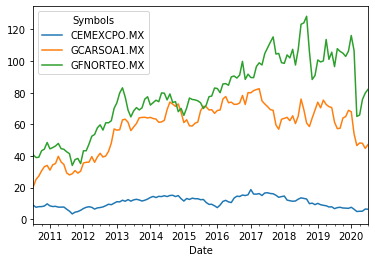

In [14]:
closes.plot()

1.2. A partir de los precios, obtener los rendimientos mensuales:

In [15]:
# Obtener rendimientos mensuales y graficar
ret = closes.pct_change().dropna()
ret.head()

Symbols,CEMEXCPO.MX,GCARSOA1.MX,GFNORTEO.MX
Date,,,
2010-08-01,-0.141903,0.229634,-0.041574
2010-09-01,0.048637,0.085244,0.004632
2010-10-01,0.003711,0.121611,0.103961
2010-11-01,0.046211,0.085179,0.024833
2010-12-01,0.163426,0.025252,0.094255


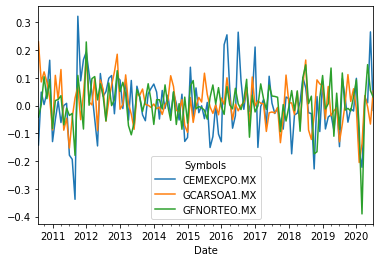

In [16]:
ret.plot()

1.3. Finalmente, a partir de los rendimientos mensuales, estimar la tendencia central de los rendimientos (rendimiento esperado), y caracterizar el riesgo de los activos (varianzas y covarianzas)

In [17]:
# Resumen: rendimiento medio mensual y volatilidad
summary = pd.DataFrame({'Media': ret.mean(), 'Vol': ret.std()})
summary

,Media,Vol
Symbols,,
CEMEXCPO.MX,0.002935,0.106644
GCARSOA1.MX,0.009621,0.072998
GFNORTEO.MX,0.009098,0.077731


In [18]:
# Matriz de covarianza
Sigma = ret.cov()
Sigma

Symbols,CEMEXCPO.MX,GCARSOA1.MX,GFNORTEO.MX
Symbols,,,
CEMEXCPO.MX,0.011373,0.002372,0.003534
GCARSOA1.MX,0.002372,0.005329,0.002118
GFNORTEO.MX,0.003534,0.002118,0.006042


In [19]:
# Matriz de correlación
R = ret.corr()
R

Symbols,CEMEXCPO.MX,GCARSOA1.MX,GFNORTEO.MX
Symbols,,,
CEMEXCPO.MX,1.000000,0.304754,0.426292
GCARSOA1.MX,0.304754,1.000000,0.373259
GFNORTEO.MX,0.426292,0.373259,1.000000


___
## 2. Selección de portafolios mediante montecarlo

Antes de continuar, consultamos la tasa libre de riesgo al día de hoy en [Banxico](http://www.banxico.org.mx/):

In [20]:
# Tasa libre de riesgo
rf = 0.0495 / 12

¿Alguien tiene alguna idea de lo que es simulación montecarlo?

En cuanto a la selección de portafolios, lo que hacemos es simular una gran cantidad de posibles portafolios que se pueden construir con los activos dados (generamos muchas ponderaciones posibles), y calculamos su rendimiento esperado y volatilidad para dibujarlos, y así poder identificar objetos de interés:

- frontera eficiente;
- portafolio de mínima varianza;
- portafolio EMV...

In [23]:
# Definimos el número de portafolios que simularemos, y la cantidad de activos que tenemos
n_act = len(summary)
n_port = 10**6

2.1. Generamos los portafolios

In [24]:
# Ayuda en la funcion numpy.random.dirichlet
help(np.random.dirichlet)

Help on built-in function dirichlet:

dirichlet(...) method of numpy.random.mtrand.RandomState instance
    dirichlet(alpha, size=None)
    
    Draw samples from the Dirichlet distribution.
    
    Draw `size` samples of dimension k from a Dirichlet distribution. A
    Dirichlet-distributed random variable can be seen as a multivariate
    generalization of a Beta distribution. The Dirichlet distribution
    is a conjugate prior of a multinomial distribution in Bayesian
    inference.
    
    .. note::
        New code should use the ``dirichlet`` method of a ``default_rng()``
        instance instead; see `random-quick-start`.
    
    Parameters
    ----------
    alpha : array
        Parameter of the distribution (k dimension for sample of
        dimension k).
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned

In [35]:
# Generar una matriz de pesos de n_port x n_act, tal que cada fila sume uno (recordar restricción)
W = np.random.dirichlet(np.ones((n_act,)), size=n_port)
W

array([[0.71818217, 0.01341604, 0.26840179],
       [0.72977702, 0.08486635, 0.18535663],
       [0.76536298, 0.09433273, 0.14030429],
       ...,
       [0.08179194, 0.91145396, 0.0067541 ],
       [0.31727532, 0.20635073, 0.47637395],
       [0.34673511, 0.11207213, 0.54119276]])

In [30]:
W.shape

(1000000, 3)

In [36]:
W.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [32]:
# Rendimientos y volatilidad de cada portafolios
Eind = summary['Media'].values
s = summary['Vol'].values
Eind, s

(array([0.00293452, 0.00962113, 0.00909761]),
 array([0.10664371, 0.07299829, 0.07773064]))

In [37]:
E_port = W.dot(Eind)

In [39]:
s_port = np.zeros((n_port,))
for i in range(n_port):
    s_port[i] = (W[i].dot(Sigma).dot(W[i]))**0.5

In [40]:
# Radio de Sharpe
RS = (E_port - rf) / s_port

In [41]:
# Data frame de resultados
portafolios = pd.DataFrame({'w(CEMEX)': W[:, 0],
                            'w(GCARSO)': W[:, 1],
                            'w(GFNORTE)': W[:, 2],
                            'Media': E_port,
                            'Vol': s_port,
                            'RS': RS}
                          )
portafolios.head()

,w(CEMEX),w(GCARSO),w(GFNORTE),Media,Vol,RS
0,0.718182,0.013416,0.268402,0.004678,0.087895,0.006296
1,0.729777,0.084866,0.185357,0.004644,0.087289,0.005950
2,0.765363,0.094333,0.140304,0.004430,0.089364,0.003413
3,0.684902,0.241493,0.073605,0.005003,0.083035,0.010573
4,0.666533,0.131948,0.201520,0.005059,0.082885,0.011266


2.2. Aproximar portafolio de mínima varianza y portafolio eficiente en media varianza

In [45]:
# Portafolio EMV
port_EMV = portafolios.loc[portafolios['RS'].idxmax()]
port_EMV

w(CEMEX)      0.000055
w(GCARSO)     0.603419
w(GFNORTE)    0.396527
Media         0.009413
Vol           0.062483
RS            0.084634
Name: 200128, dtype: float64

In [46]:
# Portafolio mínima varianza
port_minvar = portafolios.loc[portafolios['Vol'].idxmin()]
port_minvar

w(CEMEX)      0.106574
w(GCARSO)     0.508870
w(GFNORTE)    0.384556
Media         0.008707
Vol           0.061469
RS            0.074544
Name: 949101, dtype: float64

2.3. Dibujar todos los portafolios en el espacio de rendimiento esperado vs. volatilidad

[0.06, 0.11, 0.0, 0.012]

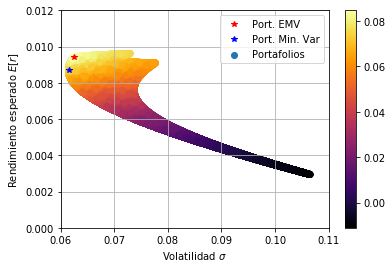

In [49]:
# Gráfica
plt.figure(figsize=(6, 4))
plt.scatter(s_port, E_port, c=RS, cmap='inferno', label='Portafolios')
# EMV
plt.plot(port_EMV['Vol'], port_EMV['Media'], '*r', label='Port. EMV')
# Min var
plt.plot(port_minvar['Vol'], port_minvar['Media'], '*b', label='Port. Min. Var')
plt.xlabel('Volatilidad $\sigma$')
plt.ylabel('Rendimiento esperado $E[r]$')
plt.legend(loc='best')
plt.grid()
plt.colorbar()
plt.axis([0.06, 0.11, 0., 0.012])

## 3. Comparar con los resultados obtenidos por optimización

3.1. Portafolio de mínima varianza

In [50]:
# Importamos funcion minimize del modulo optimize de scipy
from scipy.optimize import minimize

In [51]:
## Construcción de parámetros
# 1. Sigma: matriz de varianza-covarianza
Sigma = Sigma.values
# 2. Eind: rendimientos esperados activos individuales
Eind

array([0.00293452, 0.00962113, 0.00909761])

In [52]:
# Función objetivo
def var(w, Sigma):
    return w.T.dot(Sigma).dot(w)

In [53]:
# Dato inicial
w0 = np.ones((n_act, )) / n_act
# Cotas de las variables
bnds = ((0, 1), ) * n_act
# Restricciones
cons = {'type': 'eq', 'fun': lambda w: w.sum() - 1}

In [54]:
# Portafolio Min var
minvar = minimize(fun=var,
                  x0=w0,
                  args=(Sigma,),
                  bounds=bnds,
                  constraints=cons
                 )

In [55]:
# Comparar
minvar

     fun: 0.0037795494167769707
     jac: array([0.00753468, 0.00748664, 0.00765602])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.1035744 , 0.49801086, 0.39841474])

In [56]:
port_minvar

w(CEMEX)      0.106574
w(GCARSO)     0.508870
w(GFNORTE)    0.384556
Media         0.008707
Vol           0.061469
RS            0.074544
Name: 949101, dtype: float64

3.2. Portafolio EMV

In [ ]:
# Función objetivo


In [ ]:
# Dato inicial

# Cotas de las variables

# Restricciones


In [ ]:
# Portafolio EMV


In [ ]:
# Comparar


# Conclusión

- Tenemos una herramienta para aproximar toda la teoría de Markowitz.

- Esta herramienta no involucra optimización, solo generar números aleatorios normalizados.

- Por tanto, no le afecta el problema de dimensión (cuando tenemos muchos activos).

## Esto lo usarán en la actividad en conjunto con las demás herramientas vistas en el módulo 3 (LAC, distribución óptima de capital).

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>